# Parameters

In [ ]:
legal (1) vs non-legal 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
source_folder = '/content/drive/My Drive/BERT'
destination_folder = '/content/drive/My Drive/BERT/Model'

# Libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 4.2 MB/s 
     |████████████████████████████████| 636 kB 45.3 MB/s 
     |████████████████████████████████| 895 kB 34.3 MB/s 
     |████████████████████████████████| 3.3 MB 18.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#!pip install -U torchtext==0.9.0


In [ ]:
#pip install torchtext

In [ ]:
#pip install torch==1.8.0+cu111  -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#print(torch.__version__)

In [ ]:
#!pip install torch==1.8.0 IN the later cell i get the error cus of the version.
#when i downgrade then the progrqam pythorch is no longer compatible with torchtext.

In [ ]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

# Preliminaries
import torchtext
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Preliminaries

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field),('text', text_field)] #tried first label than text, then tried text than label

# TabularDataset


train, valid, test = TabularDataset.splits(path=source_folder, train='train_bert_bin.csv', validation='valid_bert_bin.csv',
                                           test='test_bert_bin.csv', format='CSV', fields=fields, skip_header=True)

# Iterators
#batch sizes adjusted to the 11 value dataset thatwas passed

test_iter = Iterator(test, batch_size=1, device=device, train=False, shuffle=False, sort=False)
valid_iter = BucketIterator(valid, batch_size=1, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)

train_iter = BucketIterator(train, batch_size=2, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)


In [ ]:

train

In [ ]:
source_folder = '/content/drive/My Drive/BERT'
destination_folder = '/content/drive/My Drive/BERT/Model'


In [ ]:
df = pd.read_csv('/content/drive/My Drive/BERT/train_bert_small.csv')
df.head()

,label,text
0,1,please speak to your doctor about this before ...
1,0,"she's had no chance, dwight."
2,0,jam a log between those trees!
3,0,what are you doing here?
4,1,article 37(1)


In [ ]:
df.dtypes

label     int64
text     object
dtype: object

In [ ]:
train[:20]

In [ ]:
#for x in train_iter:
#  print(x)

In [ ]:
'''
try:
    print(len(train[5]))
except:
    print(train[5].text)'''

'\ntry:\n    print(len(train[5]))\nexcept:\n    print(train[5].text)'

# Models

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
#test_iter


In [ ]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    #THIS IS REALLY IMPORTANT, CHANGE THIS
    model.train()
    for epoch in range(num_epochs):
        for (labels,  text), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, text), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [ ]:
#for count, batch in enumerate(train_iter):
 #   print(count)

#for (Label, Text), _ in train_iter:
#   print(Label)
#  print(title)
#  print(Text)
 # print(titletext)
 # print(_)

In [ ]:
'''for item in train_iter.items():
    print(item)'''

'for item in train_iter.items():\n    print(item)'

In [ ]:
#for i in train_iter:
 # print(i.label)
 # print(i.text)
  #print(i.batch_size)
  #print(i.fromvars)
  #print(i.dataset)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
len(train_iter)

2531

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [1265/12655], Train Loss: 0.3547, Valid Loss: 0.3861
Model saved to ==> /content/drive/My Drive/BERT/Model/model.pt
Model saved to ==> /content/drive/My Drive/BERT/Model/metrics.pt
Epoch [1/5], Step [2530/12655], Train Loss: 0.0913, Valid Loss: 0.5629
Epoch [2/5], Step [3795/12655], Train Loss: 0.1303, Valid Loss: 0.0582
Model saved to ==> /content/drive/My Drive/BERT/Model/model.pt
Model saved to ==> /content/drive/My Drive/BERT/Model/metrics.pt
Epoch [2/5], Step [5060/12655], Train Loss: 0.1729, Valid Loss: 2.2643
Epoch [3/5], Step [6325/12655], Train Loss: 0.4820, Valid Loss: 0.7245
Epoch [3/5], Step [7590/12655], Train Loss: 0.1629, Valid Loss: 0.3818
Epoch [4/5], Step [8855/12655], Train Loss: 0.0949, Valid Loss: 0.0587
Epoch [4/5], Step [10120/12655], Train Loss: 0.0291, Valid Loss: 0.1308
Epoch [5/5], Step [11385/12655], Train Loss: 0.0503, Valid Loss: 0.0646
Epoch [5/5], Step [12650/12655], Train Loss: 0.0426, Valid Loss: 0.1017
Model saved to ==> /content/dri

Model loaded from <== /content/drive/My Drive/BERT/Model/metrics.pt


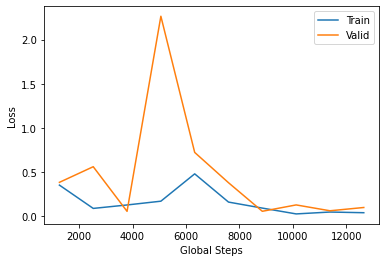

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

# Evaluation

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, text), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    #MAPPING: [0,1,2,3,4] == ['Legal', 'Medical', 'Finances', 'Tech', 'Vernacular']
    ax.xaxis.set_ticklabels(['Legal', 'Non-Legal'])
    ax.yaxis.set_ticklabels(['Legal', 'Non-Legal'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/BERT/Model/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9882    0.9862    0.9872      1016
           0     0.9792    0.9821    0.9807       671

    accuracy                         0.9846      1687
   macro avg     0.9837    0.9842    0.9839      1687
weighted avg     0.9846    0.9846    0.9846      1687



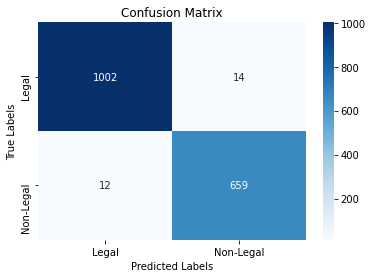

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)